In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca

ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
DEFAULT_RANDOM_SEED

41421

In [5]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "log_weighted_sum_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm": 0.02},
        }

In [6]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

    new_dir = work_dir / f"work_dir_{DEFAULT_RANDOM_SEED}"
    new_dir.mkdir(exist_ok=True)

    files = work_dir.glob("*")
    for f in files:
        if f.is_file():
            shutil.copy2(f, new_dir)
    os.chdir(new_dir)

In [45]:
def print_beam_attributes(cp, loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(
            opt_common._get_weighted_sum_intensity_from_hist(cp, hist, 2)
        ),
        "kl_divergence": lambda hist: opt_common._get_kl_divergence_with_gaussian_from_hist(cp, hist),
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [8]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange=[-detector_x / 2, detector_x / 2],
    yrange=[-detector_y / 2, detector_y / 2],
    nbins_h=1024,
    nbins_v=1024,
    use_denoised=False,
    random_seed=111,
    add_noise=True,
    calculate_over_noise=False,
    noise_threshold=1.5,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
)

xrange_plot = [x / 5 for x in cp.xrange]
yrange_plot = [y / 5 for y in cp.yrange]

ppm = opt_common.PlotParameters(
    xrange=xrange_plot, yrange=yrange_plot, nbins_h=cp.nbins_h // 5, nbins_v=cp.nbins_v // 5
)  # xrange=xrange_plot, yrange=yrange_plot)#, )

In [9]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [26]:
opt_params = OptimizationParameters()


print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['fwhm', 'log_weighted_sum_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [11]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


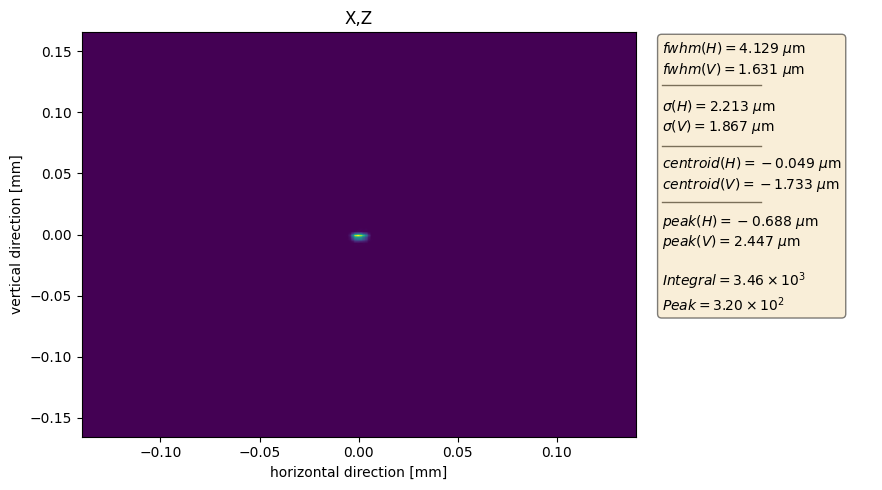

In [12]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [14]:
attribs_focus = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist, dw, "Focused beam")

Focused beam system fwhm: 8.412e-03
Focused beam system log_weighted_sum_intensity: 1.224e+01


In [15]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)

Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [16]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-186.9, -162.4, 0.17238733853924987, -0.030400000000000003, 405.0, 0.17386733853924988, -0.0039]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-18.948152126215085, -1.4173526076796996, -0.00048021640928696836, -0.015249308565823684, -14.038792803683663, 0.0019837014350059705, -0.0038997758112145064]


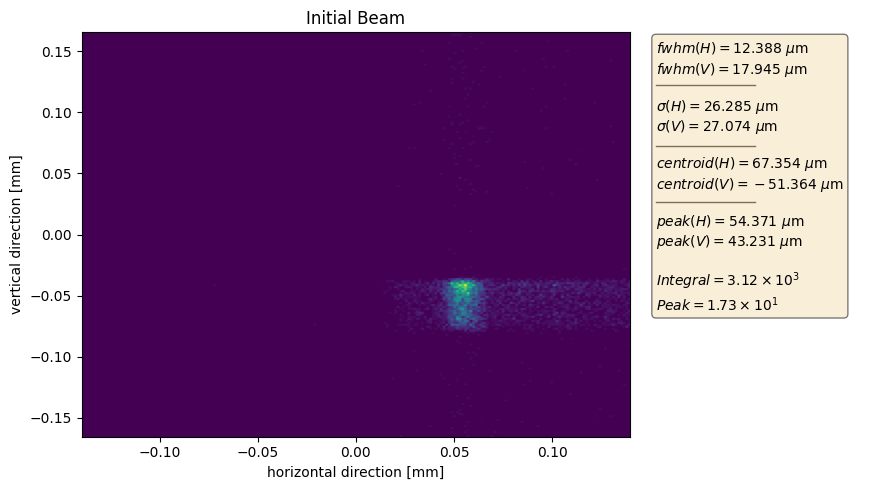

Perturbed beam system fwhm: 2.175e+00
Perturbed beam system log_weighted_sum_intensity: 1.224e+01


In [17]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

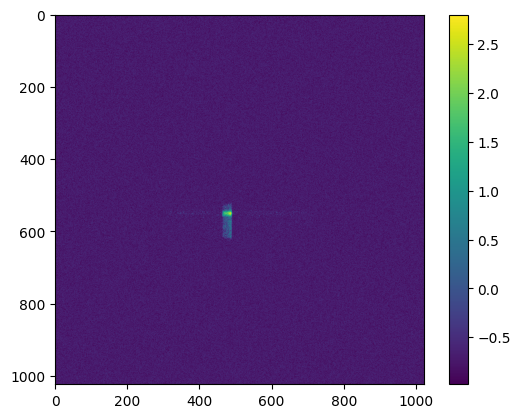

In [18]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [19]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### KL Divergence without remomving noise

In [42]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

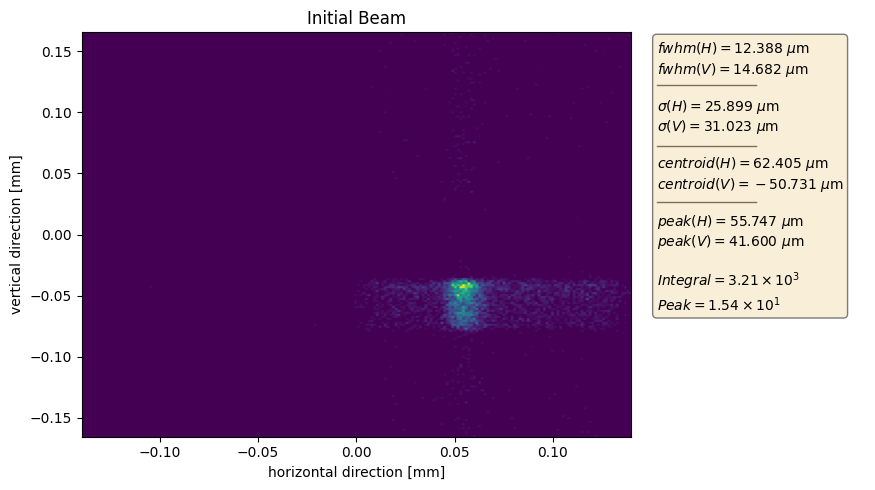

In [43]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [46]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 4.634e+00


In [47]:
opt_params = OptimizationParameters()

opt_params.params["loss_parameters"] = ["kl_divergence"]
opt_params.params["multi_objective_optimization"] = False

In [48]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (5e-3, 5e-3)},
)

In [49]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [50]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 16:49:39,124] A new study created in memory with name: no-name-b4e4a929-7e8d-4afc-a928-0ade8c834d08


In [ ]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-12 16:49:47,145] Trial 0 finished with value: 4.632636111794529 and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. Best is trial 0 with value: 4.632636111794529.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


In [ ]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

[4.625688154651509]


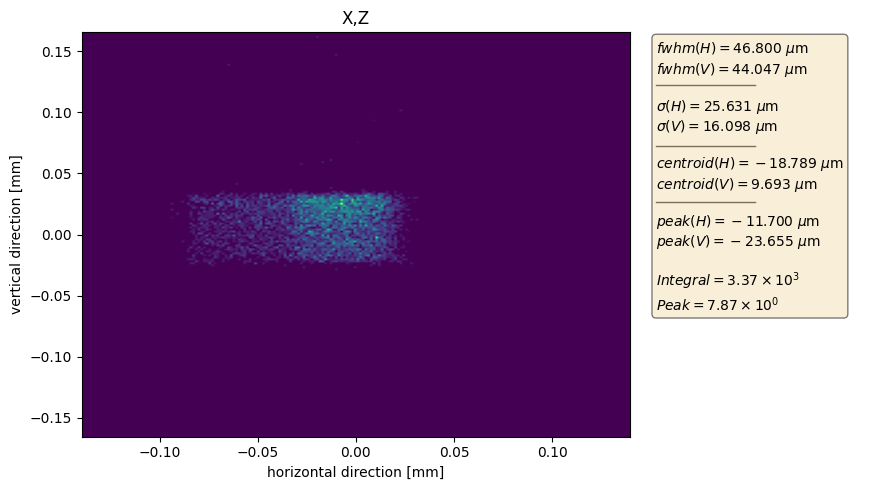

In [57]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[4.625688154651509]


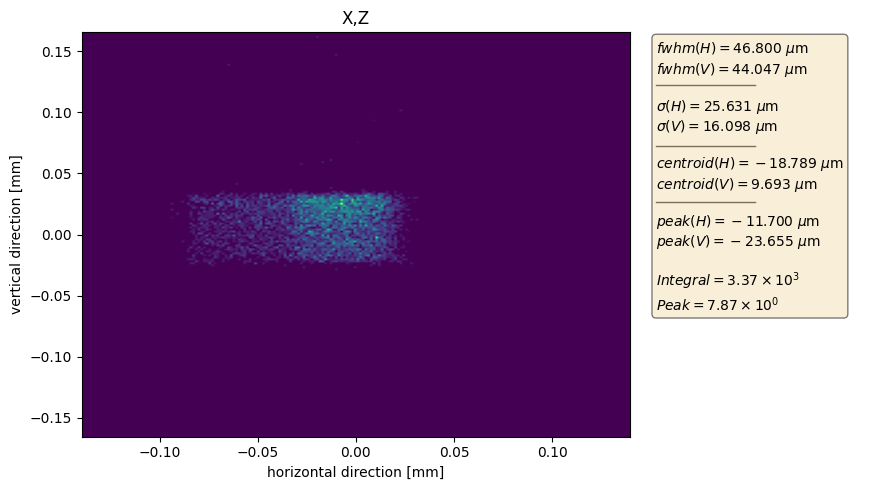

In [58]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

#### KL Divergence without removing noise, with larger fwhm

In [60]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


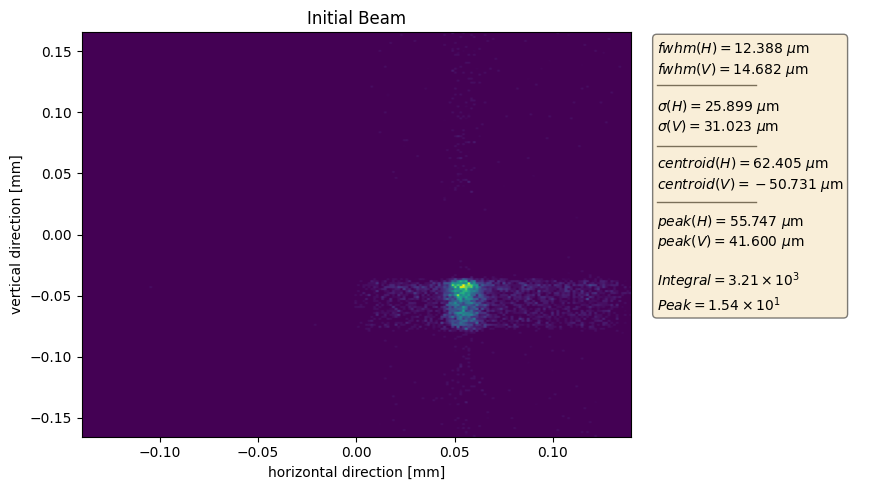

In [61]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [62]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 4.634e+00


In [63]:
opt_params = OptimizationParameters()

opt_params.params["loss_parameters"] = ["kl_divergence"]
opt_params.params["multi_objective_optimization"] = False

In [64]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (10e-3, 10e-3)},
)

In [65]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [66]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 20:15:50,658] A new study created in memory with name: no-name-921705b7-9070-4024-a574-ddb1abdd1447


In [67]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-12 20:15:59,603] Trial 0 finished with value: 4.628979812100282 and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. Best is trial 0 with value: 4.628979812100282.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:16:06,802] Trial 1 finished with value: 4.626669256677171 and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. Best is trial 1 with value: 4.626669256677171.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:16:14,549] Trial 2 finished with value: 4.625863505887593 and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. Best is trial 2 with value: 4.625863505887593.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:16:21,692] Trial 3 finished with value: 4.624929533455983 and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. Best is trial 3 with value: 4.624929533455983.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:16:28,832] Trial 4 finished with value: 4.636471147666594 and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. Best is trial 3 with value: 4.624929533455983.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:16:36,077] Trial 5 finished with value: 4.627701658001341 and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. Best is trial 3 with value: 4.624929533455983.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:16:44,018] Trial 6 finished with value: 4.627064215083659 and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. Best is trial 3 with value: 4.624929533455983.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:16:51,548] Trial 7 finished with value: 4.625161041957396 and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. Best is trial 3 with value: 4.624929533455983.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:16:59,457] Trial 8 finished with value: 4.6291946887616335 and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. Best is trial 3 with value: 4.624929533455983.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:17:06,612] Trial 9 finished with value: 4.626008116330491 and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. Best is trial 3 with value: 4.624929533455983.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:17:19,372] Trial 10 finished with value: 4.629136976567071 and parameters: {'hb_1': 21.0, 'hb_2': 18.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.022700000000000005, 'vb_bender': -4.0, 'vb_pitch': 0.0007000000000000001, 'vb_trans': 0.004700000000000003}. Best is trial 3 with value: 4.624929533455983.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:17:31,779] Trial 11 finished with value: 4.629142487584591 and parameters: {'hb_1': -16.0, 'hb_2': -7.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.0010000000000000009, 'vb_bender': 8.0, 'vb_pitch': 0.0004400000000000003, 'vb_trans': 0.020500000000000004}. Best is trial 3 with value: 4.624929533455983.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:17:44,562] Trial 12 finished with value: 4.629021345292699 and parameters: {'hb_1': 1.0, 'hb_2': -10.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.020200000000000003, 'vb_bender': 4.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.007399999999999997}. Best is trial 3 with value: 4.624929533455983.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:17:58,197] Trial 13 finished with value: 4.623436065865544 and parameters: {'hb_1': -10.0, 'hb_2': -19.0, 'hb_pitch': 0.001, 'hb_trans': -0.0121, 'vb_bender': -15.0, 'vb_pitch': 0.0002800000000000003, 'vb_trans': 0.0257}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:18:11,502] Trial 14 finished with value: 4.626232922799361 and parameters: {'hb_1': -20.0, 'hb_2': -6.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0092, 'vb_bender': 3.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0011999999999999962}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:18:23,712] Trial 15 finished with value: 4.629762438341194 and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.018000000000000002, 'vb_bender': 17.0, 'vb_pitch': 0.0012000000000000001, 'vb_trans': -0.0196}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:18:36,525] Trial 16 finished with value: 4.6292633607061715 and parameters: {'hb_1': 11.0, 'hb_2': 4.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.0158, 'vb_bender': -9.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.023299999999999998}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:18:49,337] Trial 17 finished with value: 4.629149538776851 and parameters: {'hb_1': 6.0, 'hb_2': -4.0, 'hb_pitch': 0.0013, 'hb_trans': 3.469446951953614e-18, 'vb_bender': -2.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': -0.011199999999999998}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:19:02,614] Trial 18 finished with value: 4.635166228241758 and parameters: {'hb_1': 16.0, 'hb_2': 23.0, 'hb_pitch': 0.0018, 'hb_trans': 0.013500000000000005, 'vb_bender': 16.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.002799999999999997}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:19:14,602] Trial 19 finished with value: 4.628559014819133 and parameters: {'hb_1': -15.0, 'hb_2': -13.0, 'hb_pitch': -0.0014, 'hb_trans': 0.00030000000000000165, 'vb_bender': 9.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.009599999999999997}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:19:27,543] Trial 20 finished with value: 4.6337744257790705 and parameters: {'hb_1': -21.0, 'hb_2': 3.0, 'hb_pitch': 0.0018, 'hb_trans': -0.022699999999999998, 'vb_bender': 13.0, 'vb_pitch': -0.00118, 'vb_trans': 0.024200000000000006}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:19:42,405] Trial 21 finished with value: 4.626042840877802 and parameters: {'hb_1': -19.0, 'hb_2': 21.0, 'hb_pitch': 0.0015, 'hb_trans': 0.011500000000000003, 'vb_bender': 20.0, 'vb_pitch': -0.00198, 'vb_trans': 0.012200000000000003}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and ste

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:19:55,539] Trial 22 finished with value: 4.624292524024078 and parameters: {'hb_1': 20.0, 'hb_2': -9.0, 'hb_pitch': -0.0015, 'hb_trans': 0.019000000000000003, 'vb_bender': 19.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': -0.010899999999999996}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:20:08,698] Trial 23 finished with value: 4.625924996001412 and parameters: {'hb_1': 1.0, 'hb_2': 18.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.003799999999999998, 'vb_bender': -13.0, 'vb_pitch': -0.0005, 'vb_trans': -0.0076999999999999985}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:20:22,053] Trial 24 finished with value: 4.624017446780928 and parameters: {'hb_1': -23.0, 'hb_2': -13.0, 'hb_pitch': 0.0015, 'hb_trans': 0.0075, 'vb_bender': -15.0, 'vb_pitch': 0.00082, 'vb_trans': 0.002800000000000004}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:20:35,530] Trial 25 finished with value: 4.624992462097324 and parameters: {'hb_1': -21.0, 'hb_2': -16.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.021700000000000004, 'vb_bender': -18.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.0272}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:20:49,557] Trial 26 finished with value: 4.633598392372047 and parameters: {'hb_1': 18.0, 'hb_2': 21.0, 'hb_pitch': -0.001, 'hb_trans': 0.012100000000000007, 'vb_bender': 17.0, 'vb_pitch': 0.0017800000000000003, 'vb_trans': 0.021700000000000004}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:21:03,449] Trial 27 finished with value: 4.62409161147809 and parameters: {'hb_1': -21.0, 'hb_2': 22.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.028500000000000004, 'vb_bender': 0.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.0023999999999999994}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:21:16,633] Trial 28 finished with value: 4.629725102720145 and parameters: {'hb_1': 9.0, 'hb_2': 5.0, 'hb_pitch': -0.0018, 'hb_trans': -0.011799999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': -0.015099999999999999}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:21:30,104] Trial 29 finished with value: 4.627121621078736 and parameters: {'hb_1': -2.0, 'hb_2': 20.0, 'hb_pitch': -0.0005, 'hb_trans': -0.015899999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': 0.013500000000000005}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:21:43,850] Trial 30 finished with value: 4.631074023328821 and parameters: {'hb_1': 4.0, 'hb_2': 5.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.0028999999999999963, 'vb_bender': 4.0, 'vb_pitch': -0.00174, 'vb_trans': 0.010700000000000001}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:21:57,287] Trial 31 finished with value: 4.629301947125857 and parameters: {'hb_1': -18.0, 'hb_2': -22.0, 'hb_pitch': -0.0013, 'hb_trans': 0.025300000000000003, 'vb_bender': 10.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': 3.469446951953614e-18}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:22:11,629] Trial 32 finished with value: 4.632702049852053 and parameters: {'hb_1': 20.0, 'hb_2': -25.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.012199999999999999, 'vb_bender': 16.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': -0.0295}. Best is trial 13 with value: 4.623436065865544.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:22:23,985] Trial 33 finished with value: 4.615123028754465 and parameters: {'hb_1': 8.0, 'hb_2': 17.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.029099999999999997, 'vb_bender': 16.0, 'vb_pitch': -0.0009, 'vb_trans': -0.011699999999999999}. Best is trial 33 with value: 4.615123028754465.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:22:38,570] Trial 34 finished with value: 4.62723371235104 and parameters: {'hb_1': 14.0, 'hb_2': -12.0, 'hb_pitch': -0.0018, 'hb_trans': -0.013399999999999999, 'vb_bender': -6.0, 'vb_pitch': -0.00108, 'vb_trans': 0.009900000000000006}. Best is trial 33 with value: 4.615123028754465.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:22:54,600] Trial 35 finished with value: 4.609321586680401 and parameters: {'hb_1': 12.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.0053999999999999986, 'vb_bender': -5.0, 'vb_pitch': 0.0006200000000000003, 'vb_trans': 0.004200000000000002}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:23:09,112] Trial 36 finished with value: 4.625405445329749 and parameters: {'hb_1': -24.0, 'hb_2': -16.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0165, 'vb_bender': -3.0, 'vb_pitch': 0.00136, 'vb_trans': -0.019299999999999998}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:23:22,676] Trial 37 finished with value: 4.629255820716756 and parameters: {'hb_1': -19.0, 'hb_2': 12.0, 'hb_pitch': -0.0019, 'hb_trans': -0.008299999999999998, 'vb_bender': 7.0, 'vb_pitch': -0.0015, 'vb_trans': -0.000499999999999997}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:23:37,708] Trial 38 finished with value: 4.627038340940777 and parameters: {'hb_1': -7.0, 'hb_2': 14.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.022000000000000006, 'vb_bender': 0.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0020000000000000018}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:23:51,268] Trial 39 finished with value: 4.627825836031592 and parameters: {'hb_1': 18.0, 'hb_2': 16.0, 'hb_pitch': -0.0018, 'hb_trans': 0.027200000000000002, 'vb_bender': -14.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': -0.0281}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:24:04,924] Trial 40 finished with value: 4.62747642441007 and parameters: {'hb_1': 8.0, 'hb_2': 2.0, 'hb_pitch': 0.0, 'hb_trans': -0.014999999999999998, 'vb_bender': -14.0, 'vb_pitch': -0.00056, 'vb_trans': -0.0287}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:24:19,667] Trial 41 finished with value: 4.632828451497613 and parameters: {'hb_1': 6.0, 'hb_2': 8.0, 'hb_pitch': -0.0018, 'hb_trans': 0.022900000000000004, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.009799999999999996}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:24:34,669] Trial 42 finished with value: 4.625287066232904 and parameters: {'hb_1': 11.0, 'hb_2': 10.0, 'hb_pitch': -0.0019, 'hb_trans': -0.024399999999999998, 'vb_bender': -16.0, 'vb_pitch': 0.00196, 'vb_trans': 0.020200000000000003}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:24:48,356] Trial 43 finished with value: 4.626603552943514 and parameters: {'hb_1': 5.0, 'hb_2': -3.0, 'hb_pitch': 0.0, 'hb_trans': 0.006000000000000005, 'vb_bender': -17.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': 0.014500000000000006}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:25:02,858] Trial 44 finished with value: 4.630943668847699 and parameters: {'hb_1': -5.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.0184, 'vb_bender': 17.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': -0.0231}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:25:16,519] Trial 45 finished with value: 4.625022522753772 and parameters: {'hb_1': 7.0, 'hb_2': -24.0, 'hb_pitch': -0.0014, 'hb_trans': -0.0281, 'vb_bender': -11.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': -0.0232}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, bu

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:25:30,467] Trial 46 finished with value: 4.628671779170737 and parameters: {'hb_1': 21.0, 'hb_2': -1.0, 'hb_pitch': -0.001, 'hb_trans': -0.012999999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0092}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:25:44,334] Trial 47 finished with value: 4.62699355166124 and parameters: {'hb_1': 0.0, 'hb_2': 14.0, 'hb_pitch': 0.0, 'hb_trans': -0.016599999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.00076, 'vb_trans': 0.008300000000000002}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.00

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:25:59,547] Trial 48 finished with value: 4.627850019700813 and parameters: {'hb_1': 15.0, 'hb_2': 13.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': -0.0081, 'vb_bender': -6.0, 'vb_pitch': -0.00172, 'vb_trans': -0.026199999999999998}. Best is trial 35 with value: 4.609321586680401.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:13,426] Trial 49 finished with value: 4.628661061052756 and parameters: {'hb_1': 13.0, 'hb_2': 11.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.000499999999999997, 'vb_bender': -4.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.0272}. Best is trial 35 with value: 4.609321586680401.


In [68]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

1.5280806849385853 207115.5551739084


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.
[4.609321586680401]


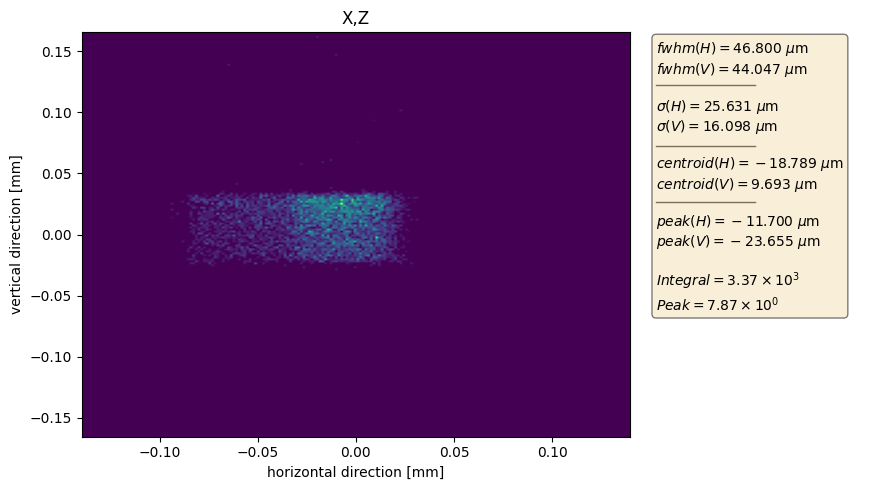

In [69]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[4.609321586680401]


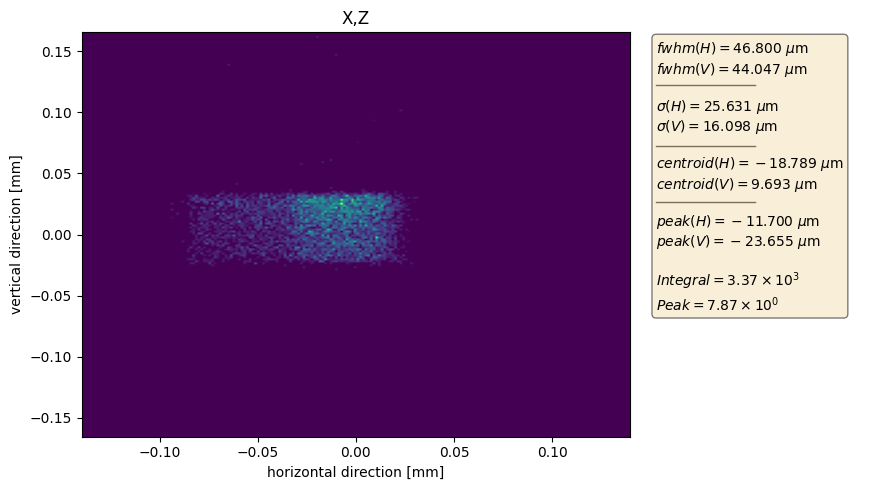

In [70]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

/tmp/ipykernel_3879159/1243347140.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

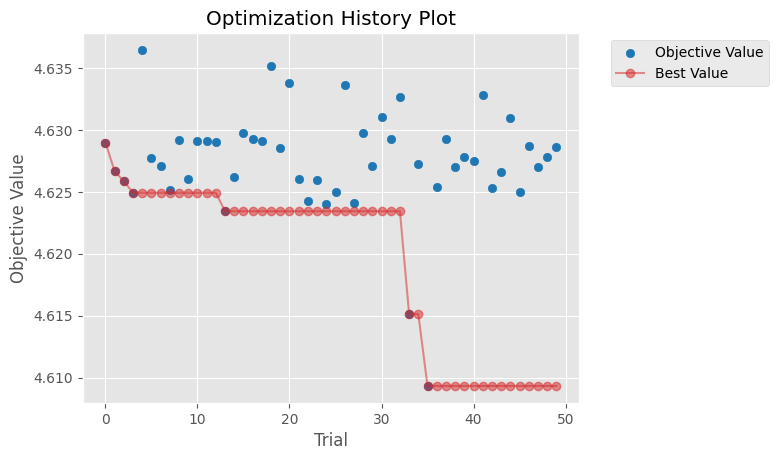

In [71]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)

#### KL Divergence after removing noise

In [72]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

In [73]:
cp = dt.replace(cp, calculate_over_noise=True)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


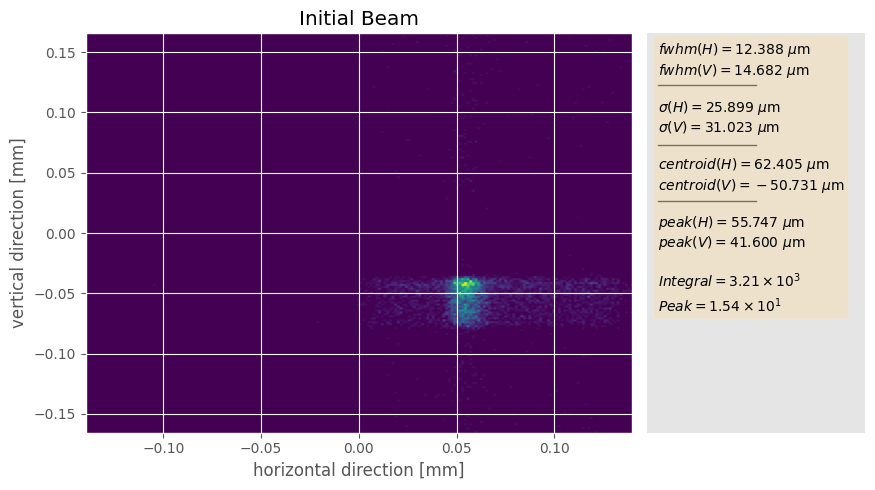

In [74]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [77]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.118e+01


In [78]:
opt_params = OptimizationParameters()

opt_params.params["loss_parameters"] = ["kl_divergence"]
opt_params.params["multi_objective_optimization"] = False

In [79]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (5e-3, 5e-3)},
)

In [80]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [81]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 20:28:36,644] A new study created in memory with name: no-name-d0c63bdc-5973-4cee-b79c-1d4b02c45e81


In [82]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-12 20:29:30,116] Trial 0 finished with value: 11.184709973072419 and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. Best is trial 0 with value: 11.184709973072419.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:39,093] Trial 1 finished with value: 10.760073677074672 and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. Best is trial 1 with value: 10.760073677074672.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:46,833] Trial 2 finished with value: 10.43872839361391 and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. Best is trial 2 with value: 10.43872839361391.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:54,852] Trial 3 finished with value: 10.35129411978114 and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. Best is trial 3 with value: 10.35129411978114.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:02,463] Trial 4 finished with value: 12.889025728730875 and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. Best is trial 3 with value: 10.35129411978114.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:10,318] Trial 5 finished with value: 11.021919156402118 and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. Best is trial 3 with value: 10.35129411978114.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:19,473] Trial 6 finished with value: 11.451191444895361 and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. Best is trial 3 with value: 10.35129411978114.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:27,685] Trial 7 finished with value: 10.23043431546914 and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. Best is trial 7 with value: 10.23043431546914.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:35,999] Trial 8 finished with value: 11.501861816544562 and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. Best is trial 7 with value: 10.23043431546914.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:46,678] Trial 9 finished with value: 10.690946779370655 and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:00,462] Trial 10 finished with value: 11.163099083424491 and parameters: {'hb_1': 21.0, 'hb_2': 18.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.022700000000000005, 'vb_bender': -4.0, 'vb_pitch': 0.0007000000000000001, 'vb_trans': 0.004700000000000003}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:13,951] Trial 11 finished with value: 11.331190629267454 and parameters: {'hb_1': -16.0, 'hb_2': -7.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.0010000000000000009, 'vb_bender': 8.0, 'vb_pitch': 0.0004400000000000003, 'vb_trans': 0.020500000000000004}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:29,042] Trial 12 finished with value: 11.197007525817037 and parameters: {'hb_1': 1.0, 'hb_2': -10.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.020200000000000003, 'vb_bender': 4.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.007399999999999997}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:43,141] Trial 13 finished with value: 10.271370363107692 and parameters: {'hb_1': -10.0, 'hb_2': -19.0, 'hb_pitch': 0.001, 'hb_trans': -0.0121, 'vb_bender': -15.0, 'vb_pitch': 0.0002800000000000003, 'vb_trans': 0.0257}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:57,569] Trial 14 finished with value: 10.909915665439677 and parameters: {'hb_1': -20.0, 'hb_2': -6.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0092, 'vb_bender': 3.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0011999999999999962}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:32:11,687] Trial 15 finished with value: 11.403900570997422 and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.018000000000000002, 'vb_bender': 17.0, 'vb_pitch': 0.0012000000000000001, 'vb_trans': -0.0196}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:32:24,775] Trial 16 finished with value: 11.364303624308386 and parameters: {'hb_1': 11.0, 'hb_2': 4.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.0158, 'vb_bender': -9.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.023299999999999998}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:32:39,734] Trial 17 finished with value: 11.302229225974607 and parameters: {'hb_1': 6.0, 'hb_2': -4.0, 'hb_pitch': 0.0013, 'hb_trans': 3.469446951953614e-18, 'vb_bender': -2.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': -0.011199999999999998}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:32:52,683] Trial 18 finished with value: 12.385521207344283 and parameters: {'hb_1': 16.0, 'hb_2': 23.0, 'hb_pitch': 0.0018, 'hb_trans': 0.013500000000000005, 'vb_bender': 16.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.002799999999999997}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:33:05,866] Trial 19 finished with value: 11.159716866687923 and parameters: {'hb_1': -15.0, 'hb_2': -13.0, 'hb_pitch': -0.0014, 'hb_trans': 0.00030000000000000165, 'vb_bender': 9.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.009599999999999997}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:33:19,709] Trial 20 finished with value: 12.497729036835379 and parameters: {'hb_1': -21.0, 'hb_2': 3.0, 'hb_pitch': 0.0018, 'hb_trans': -0.022699999999999998, 'vb_bender': 13.0, 'vb_pitch': -0.00118, 'vb_trans': 0.024200000000000006}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and ste

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:33:33,863] Trial 21 finished with value: 11.116897875925037 and parameters: {'hb_1': -19.0, 'hb_2': 21.0, 'hb_pitch': 0.0015, 'hb_trans': 0.011500000000000003, 'vb_bender': 20.0, 'vb_pitch': -0.00198, 'vb_trans': 0.012200000000000003}. Best is trial 7 with value: 10.23043431546914.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and ste

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:33:48,534] Trial 22 finished with value: 9.935530236185738 and parameters: {'hb_1': 20.0, 'hb_2': -9.0, 'hb_pitch': -0.0015, 'hb_trans': 0.019000000000000003, 'vb_bender': 19.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': -0.010899999999999996}. Best is trial 22 with value: 9.935530236185738.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:34:03,713] Trial 23 finished with value: 10.493146011463331 and parameters: {'hb_1': 1.0, 'hb_2': 18.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.003799999999999998, 'vb_bender': -13.0, 'vb_pitch': -0.0005, 'vb_trans': -0.0076999999999999985}. Best is trial 22 with value: 9.935530236185738.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:34:17,891] Trial 24 finished with value: 10.192302086205714 and parameters: {'hb_1': -23.0, 'hb_2': -13.0, 'hb_pitch': 0.0015, 'hb_trans': 0.0075, 'vb_bender': -15.0, 'vb_pitch': 0.00082, 'vb_trans': 0.002800000000000004}. Best is trial 22 with value: 9.935530236185738.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, bu

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:34:32,123] Trial 25 finished with value: 10.22844360574803 and parameters: {'hb_1': -21.0, 'hb_2': -16.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.021700000000000004, 'vb_bender': -18.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.0272}. Best is trial 22 with value: 9.935530236185738.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:34:45,804] Trial 26 finished with value: 12.218821329537338 and parameters: {'hb_1': 18.0, 'hb_2': 21.0, 'hb_pitch': -0.001, 'hb_trans': 0.012100000000000007, 'vb_bender': 17.0, 'vb_pitch': 0.0017800000000000003, 'vb_trans': 0.021700000000000004}. Best is trial 22 with value: 9.935530236185738.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:35:00,350] Trial 27 finished with value: 9.798448064139082 and parameters: {'hb_1': -21.0, 'hb_2': 22.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.028500000000000004, 'vb_bender': 0.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.0023999999999999994}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:35:15,181] Trial 28 finished with value: 11.58754895583368 and parameters: {'hb_1': 9.0, 'hb_2': 5.0, 'hb_pitch': -0.0018, 'hb_trans': -0.011799999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': -0.015099999999999999}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:35:30,652] Trial 29 finished with value: 10.913841475098142 and parameters: {'hb_1': -2.0, 'hb_2': 20.0, 'hb_pitch': -0.0005, 'hb_trans': -0.015899999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': 0.013500000000000005}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:35:45,149] Trial 30 finished with value: 11.71184585182182 and parameters: {'hb_1': 4.0, 'hb_2': 5.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.0028999999999999963, 'vb_bender': 4.0, 'vb_pitch': -0.00174, 'vb_trans': 0.010700000000000001}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:36:00,119] Trial 31 finished with value: 11.231295982422274 and parameters: {'hb_1': -18.0, 'hb_2': -22.0, 'hb_pitch': -0.0013, 'hb_trans': 0.025300000000000003, 'vb_bender': 10.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': 3.469446951953614e-18}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:36:14,290] Trial 32 finished with value: 12.305013176258623 and parameters: {'hb_1': 20.0, 'hb_2': -25.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.012199999999999999, 'vb_bender': 16.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': -0.0295}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:36:27,196] Trial 33 finished with value: 10.646233441576214 and parameters: {'hb_1': 8.0, 'hb_2': 17.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.029099999999999997, 'vb_bender': 16.0, 'vb_pitch': -0.0009, 'vb_trans': -0.011699999999999999}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:36:41,019] Trial 34 finished with value: 10.93245942052476 and parameters: {'hb_1': 14.0, 'hb_2': -12.0, 'hb_pitch': -0.0018, 'hb_trans': -0.013399999999999999, 'vb_bender': -6.0, 'vb_pitch': -0.00108, 'vb_trans': 0.009900000000000006}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:36:54,648] Trial 35 finished with value: 10.054496170973303 and parameters: {'hb_1': 12.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.0053999999999999986, 'vb_bender': -5.0, 'vb_pitch': 0.0006200000000000003, 'vb_trans': 0.004200000000000002}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:37:08,323] Trial 36 finished with value: 10.499303264707521 and parameters: {'hb_1': -24.0, 'hb_2': -16.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0165, 'vb_bender': -3.0, 'vb_pitch': 0.00136, 'vb_trans': -0.019299999999999998}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:37:22,091] Trial 37 finished with value: 11.334674188700129 and parameters: {'hb_1': -19.0, 'hb_2': 12.0, 'hb_pitch': -0.0019, 'hb_trans': -0.008299999999999998, 'vb_bender': 7.0, 'vb_pitch': -0.0015, 'vb_trans': -0.000499999999999997}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:37:35,283] Trial 38 finished with value: 10.842917814201902 and parameters: {'hb_1': -7.0, 'hb_2': 14.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.022000000000000006, 'vb_bender': 0.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0020000000000000018}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:37:50,320] Trial 39 finished with value: 11.007905747682042 and parameters: {'hb_1': 18.0, 'hb_2': 16.0, 'hb_pitch': -0.0018, 'hb_trans': 0.027200000000000002, 'vb_bender': -14.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': -0.0281}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:38:04,541] Trial 40 finished with value: 11.1161452654049 and parameters: {'hb_1': 8.0, 'hb_2': 2.0, 'hb_pitch': 0.0, 'hb_trans': -0.014999999999999998, 'vb_bender': -14.0, 'vb_pitch': -0.00056, 'vb_trans': -0.0287}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:38:18,491] Trial 41 finished with value: 12.020916328446509 and parameters: {'hb_1': 6.0, 'hb_2': 8.0, 'hb_pitch': -0.0018, 'hb_trans': 0.022900000000000004, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.009799999999999996}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:38:33,900] Trial 42 finished with value: 10.528811345807313 and parameters: {'hb_1': 11.0, 'hb_2': 10.0, 'hb_pitch': -0.0019, 'hb_trans': -0.024399999999999998, 'vb_bender': -16.0, 'vb_pitch': 0.00196, 'vb_trans': 0.020200000000000003}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:38:48,860] Trial 43 finished with value: 10.802556773198388 and parameters: {'hb_1': 5.0, 'hb_2': -3.0, 'hb_pitch': 0.0, 'hb_trans': 0.006000000000000005, 'vb_bender': -17.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': 0.014500000000000006}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:39:03,871] Trial 44 finished with value: 11.959091477395946 and parameters: {'hb_1': -5.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.0184, 'vb_bender': 17.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': -0.0231}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:39:18,541] Trial 45 finished with value: 10.486306591362192 and parameters: {'hb_1': 7.0, 'hb_2': -24.0, 'hb_pitch': -0.0014, 'hb_trans': -0.0281, 'vb_bender': -11.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': -0.0232}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, b

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:39:33,378] Trial 46 finished with value: 11.28656594447991 and parameters: {'hb_1': 21.0, 'hb_2': -1.0, 'hb_pitch': -0.001, 'hb_trans': -0.012999999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0092}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:39:47,996] Trial 47 finished with value: 11.059460427459854 and parameters: {'hb_1': 0.0, 'hb_2': 14.0, 'hb_pitch': 0.0, 'hb_trans': -0.016599999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.00076, 'vb_trans': 0.008300000000000002}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:40:03,487] Trial 48 finished with value: 11.163736834802647 and parameters: {'hb_1': 15.0, 'hb_2': 13.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': -0.0081, 'vb_bender': -6.0, 'vb_pitch': -0.00172, 'vb_trans': -0.026199999999999998}. Best is trial 27 with value: 9.798448064139082.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:40:19,662] Trial 49 finished with value: 11.32919926801805 and parameters: {'hb_1': 13.0, 'hb_2': 11.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.000499999999999997, 'vb_bender': -4.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.0272}. Best is trial 27 with value: 9.798448064139082.


In [83]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

2.2822240123339963 201.18782185543236


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.
[9.798448064139082]


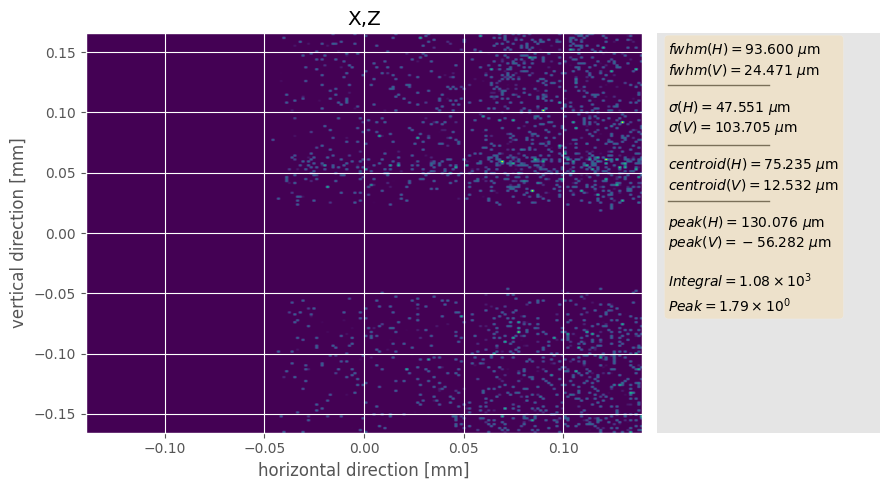

In [84]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[9.798448064139082]


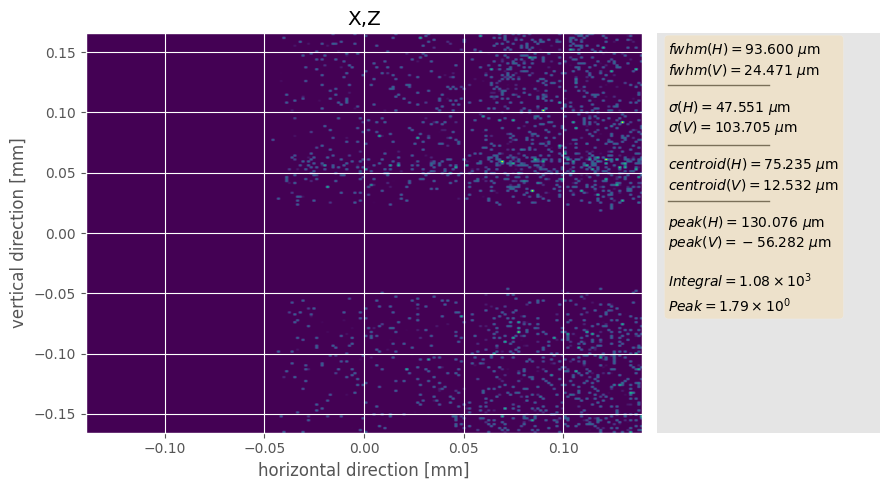

In [85]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

/tmp/ipykernel_3879159/1243347140.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

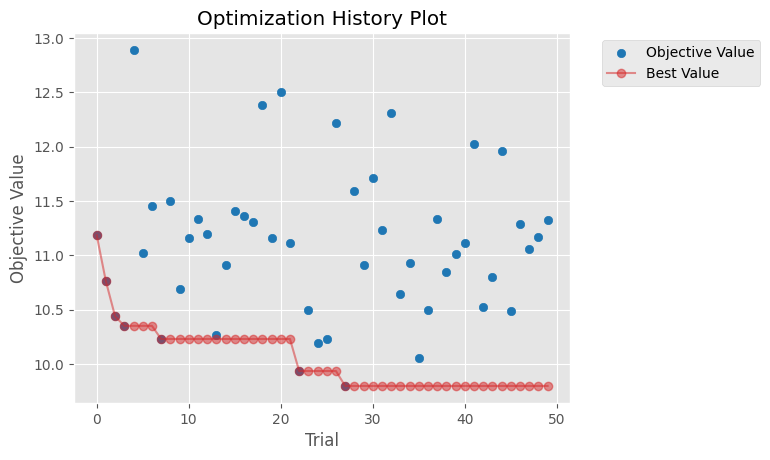

In [86]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)

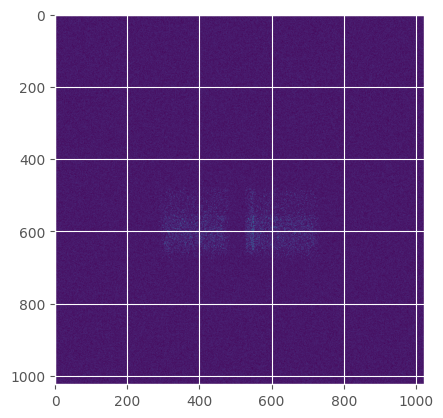

In [87]:
plt.imshow(opt_trial.beam_state.hist.data_2D)

#### KL Divergence removing noise, with larger fwhm

In [88]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

In [89]:
cp

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=True, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


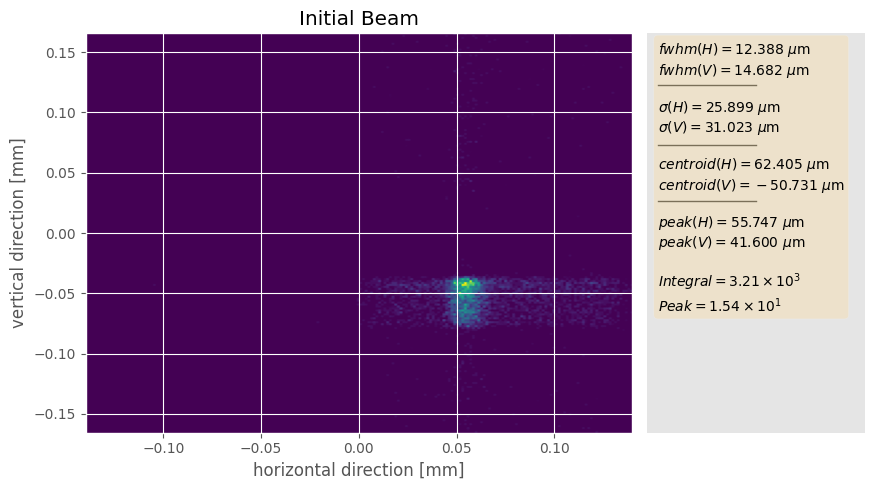

In [90]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [91]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.118e+01


In [92]:
opt_params = OptimizationParameters()

opt_params.params["loss_parameters"] = ["kl_divergence"]
opt_params.params["multi_objective_optimization"] = False

In [93]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (10e-3, 10e-3)},
)

In [94]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [95]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 21:01:34,380] A new study created in memory with name: no-name-283fd4f6-100a-4437-9a25-07504f4dd245


In [96]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-12 21:01:43,305] Trial 0 finished with value: 11.172432069603357 and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. Best is trial 0 with value: 11.172432069603357.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:01:51,031] Trial 1 finished with value: 10.763511264515474 and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. Best is trial 1 with value: 10.763511264515474.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:00,032] Trial 2 finished with value: 10.402497831881835 and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. Best is trial 2 with value: 10.402497831881835.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:08,053] Trial 3 finished with value: 10.352173643777103 and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. Best is trial 3 with value: 10.352173643777103.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:16,662] Trial 4 finished with value: 12.88776637832479 and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. Best is trial 3 with value: 10.352173643777103.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:24,538] Trial 5 finished with value: 11.023000997104004 and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. Best is trial 3 with value: 10.352173643777103.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:33,077] Trial 6 finished with value: 11.074992430807308 and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. Best is trial 3 with value: 10.352173643777103.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:41,331] Trial 7 finished with value: 10.238559417538669 and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. Best is trial 7 with value: 10.238559417538669.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:50,098] Trial 8 finished with value: 11.494307639645692 and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. Best is trial 7 with value: 10.238559417538669.


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:58,196] Trial 9 finished with value: 10.697354556410462 and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. Best is trial 7 with value: 10.238559417538669.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, bu

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:13,047] Trial 10 finished with value: 11.167825551872948 and parameters: {'hb_1': 21.0, 'hb_2': 18.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.022700000000000005, 'vb_bender': -4.0, 'vb_pitch': 0.0007000000000000001, 'vb_trans': 0.004700000000000003}. Best is trial 7 with value: 10.238559417538669.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:27,698] Trial 11 finished with value: 11.322111150242542 and parameters: {'hb_1': -16.0, 'hb_2': -7.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.0010000000000000009, 'vb_bender': 8.0, 'vb_pitch': 0.0004400000000000003, 'vb_trans': 0.020500000000000004}. Best is trial 7 with value: 10.238559417538669.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:41,042] Trial 12 finished with value: 11.199896322867893 and parameters: {'hb_1': 1.0, 'hb_2': -10.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.020200000000000003, 'vb_bender': 4.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.007399999999999997}. Best is trial 7 with value: 10.238559417538669.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:55,001] Trial 13 finished with value: 10.070434209081002 and parameters: {'hb_1': -10.0, 'hb_2': -19.0, 'hb_pitch': 0.001, 'hb_trans': -0.0121, 'vb_bender': -15.0, 'vb_pitch': 0.0002800000000000003, 'vb_trans': 0.0257}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, b

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:09,100] Trial 14 finished with value: 10.682966186582995 and parameters: {'hb_1': -20.0, 'hb_2': -6.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0092, 'vb_bender': 3.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0011999999999999962}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:23,573] Trial 15 finished with value: 11.403547148498598 and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.018000000000000002, 'vb_bender': 17.0, 'vb_pitch': 0.0012000000000000001, 'vb_trans': -0.0196}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:40,964] Trial 16 finished with value: 11.359497289427066 and parameters: {'hb_1': 11.0, 'hb_2': 4.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.0158, 'vb_bender': -9.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.023299999999999998}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:55,812] Trial 17 finished with value: 11.307409882808788 and parameters: {'hb_1': 6.0, 'hb_2': -4.0, 'hb_pitch': 0.0013, 'hb_trans': 3.469446951953614e-18, 'vb_bender': -2.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': -0.011199999999999998}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:11,814] Trial 18 finished with value: 12.386854103539742 and parameters: {'hb_1': 16.0, 'hb_2': 23.0, 'hb_pitch': 0.0018, 'hb_trans': 0.013500000000000005, 'vb_bender': 16.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.002799999999999997}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:26,574] Trial 19 finished with value: 11.151100391329244 and parameters: {'hb_1': -15.0, 'hb_2': -13.0, 'hb_pitch': -0.0014, 'hb_trans': 0.00030000000000000165, 'vb_bender': 9.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.009599999999999997}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:41,216] Trial 20 finished with value: 12.507664464429126 and parameters: {'hb_1': -21.0, 'hb_2': 3.0, 'hb_pitch': 0.0018, 'hb_trans': -0.022699999999999998, 'vb_bender': 13.0, 'vb_pitch': -0.00118, 'vb_trans': 0.024200000000000006}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:56,607] Trial 21 finished with value: 10.775925213980665 and parameters: {'hb_1': -19.0, 'hb_2': 21.0, 'hb_pitch': 0.0015, 'hb_trans': 0.011500000000000003, 'vb_bender': 20.0, 'vb_pitch': -0.00198, 'vb_trans': 0.012200000000000003}. Best is trial 13 with value: 10.070434209081002.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:11,005] Trial 22 finished with value: 9.939284102967813 and parameters: {'hb_1': 20.0, 'hb_2': -9.0, 'hb_pitch': -0.0015, 'hb_trans': 0.019000000000000003, 'vb_bender': 19.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': -0.010899999999999996}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:27,112] Trial 23 finished with value: 10.498361004506656 and parameters: {'hb_1': 1.0, 'hb_2': 18.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.003799999999999998, 'vb_bender': -13.0, 'vb_pitch': -0.0005, 'vb_trans': -0.0076999999999999985}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:42,500] Trial 24 finished with value: 10.054125483451953 and parameters: {'hb_1': -23.0, 'hb_2': -13.0, 'hb_pitch': 0.0015, 'hb_trans': 0.0075, 'vb_bender': -15.0, 'vb_pitch': 0.00082, 'vb_trans': 0.002800000000000004}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, bu

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:57,785] Trial 25 finished with value: 10.212405606650394 and parameters: {'hb_1': -21.0, 'hb_2': -16.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.021700000000000004, 'vb_bender': -18.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.0272}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:13,320] Trial 26 finished with value: 12.215085131069003 and parameters: {'hb_1': 18.0, 'hb_2': 21.0, 'hb_pitch': -0.001, 'hb_trans': 0.012100000000000007, 'vb_bender': 17.0, 'vb_pitch': 0.0017800000000000003, 'vb_trans': 0.021700000000000004}. Best is trial 22 with value: 9.939284102967813.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:27,742] Trial 27 finished with value: 9.80157121430759 and parameters: {'hb_1': -21.0, 'hb_2': 22.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.028500000000000004, 'vb_bender': 0.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.0023999999999999994}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:43,066] Trial 28 finished with value: 11.592156170312942 and parameters: {'hb_1': 9.0, 'hb_2': 5.0, 'hb_pitch': -0.0018, 'hb_trans': -0.011799999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': -0.015099999999999999}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:58,068] Trial 29 finished with value: 10.917117024445567 and parameters: {'hb_1': -2.0, 'hb_2': 20.0, 'hb_pitch': -0.0005, 'hb_trans': -0.015899999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': 0.013500000000000005}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:12,692] Trial 30 finished with value: 11.712240769887805 and parameters: {'hb_1': 4.0, 'hb_2': 5.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.0028999999999999963, 'vb_bender': 4.0, 'vb_pitch': -0.00174, 'vb_trans': 0.010700000000000001}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:27,874] Trial 31 finished with value: 11.222460247218118 and parameters: {'hb_1': -18.0, 'hb_2': -22.0, 'hb_pitch': -0.0013, 'hb_trans': 0.025300000000000003, 'vb_bender': 10.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': 3.469446951953614e-18}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:43,905] Trial 32 finished with value: 12.3113145737943 and parameters: {'hb_1': 20.0, 'hb_2': -25.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.012199999999999999, 'vb_bender': 16.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': -0.0295}. Best is trial 27 with value: 9.80157121430759.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:58,703] Trial 33 finished with value: 9.272964270525236 and parameters: {'hb_1': 8.0, 'hb_2': 17.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.029099999999999997, 'vb_bender': 16.0, 'vb_pitch': -0.0009, 'vb_trans': -0.011699999999999999}. Best is trial 33 with value: 9.272964270525236.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:14,462] Trial 34 finished with value: 10.927231640442692 and parameters: {'hb_1': 14.0, 'hb_2': -12.0, 'hb_pitch': -0.0018, 'hb_trans': -0.013399999999999999, 'vb_bender': -6.0, 'vb_pitch': -0.00108, 'vb_trans': 0.009900000000000006}. Best is trial 33 with value: 9.272964270525236.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:29,627] Trial 35 finished with value: 8.068679916808227 and parameters: {'hb_1': 12.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.0053999999999999986, 'vb_bender': -5.0, 'vb_pitch': 0.0006200000000000003, 'vb_trans': 0.004200000000000002}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:44,316] Trial 36 finished with value: 10.500571622525115 and parameters: {'hb_1': -24.0, 'hb_2': -16.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0165, 'vb_bender': -3.0, 'vb_pitch': 0.00136, 'vb_trans': -0.019299999999999998}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:01,591] Trial 37 finished with value: 11.338223891015572 and parameters: {'hb_1': -19.0, 'hb_2': 12.0, 'hb_pitch': -0.0019, 'hb_trans': -0.008299999999999998, 'vb_bender': 7.0, 'vb_pitch': -0.0015, 'vb_trans': -0.000499999999999997}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:19,766] Trial 38 finished with value: 10.765706008176352 and parameters: {'hb_1': -7.0, 'hb_2': 14.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.022000000000000006, 'vb_bender': 0.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0020000000000000018}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:34,390] Trial 39 finished with value: 11.008107604908556 and parameters: {'hb_1': 18.0, 'hb_2': 16.0, 'hb_pitch': -0.0018, 'hb_trans': 0.027200000000000002, 'vb_bender': -14.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': -0.0281}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:57,782] Trial 40 finished with value: 11.114999104103022 and parameters: {'hb_1': 8.0, 'hb_2': 2.0, 'hb_pitch': 0.0, 'hb_trans': -0.014999999999999998, 'vb_bender': -14.0, 'vb_pitch': -0.00056, 'vb_trans': -0.0287}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but th

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:11:14,822] Trial 41 finished with value: 12.019697798877367 and parameters: {'hb_1': 6.0, 'hb_2': 8.0, 'hb_pitch': -0.0018, 'hb_trans': 0.022900000000000004, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.009799999999999996}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.00190000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:11:30,627] Trial 42 finished with value: 10.527725210809999 and parameters: {'hb_1': 11.0, 'hb_2': 10.0, 'hb_pitch': -0.0019, 'hb_trans': -0.024399999999999998, 'vb_bender': -16.0, 'vb_pitch': 0.00196, 'vb_trans': 0.020200000000000003}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:11:45,561] Trial 43 finished with value: 10.722330958159437 and parameters: {'hb_1': 5.0, 'hb_2': -3.0, 'hb_pitch': 0.0, 'hb_trans': 0.006000000000000005, 'vb_bender': -17.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': 0.014500000000000006}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.001900000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:01,689] Trial 44 finished with value: 11.954316925937318 and parameters: {'hb_1': -5.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.0184, 'vb_bender': 17.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': -0.0231}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:19,987] Trial 45 finished with value: 10.491461934027358 and parameters: {'hb_1': 7.0, 'hb_2': -24.0, 'hb_pitch': -0.0014, 'hb_trans': -0.0281, 'vb_bender': -11.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': -0.0232}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, b

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:40,786] Trial 46 finished with value: 11.282122270399439 and parameters: {'hb_1': 21.0, 'hb_2': -1.0, 'hb_pitch': -0.001, 'hb_trans': -0.012999999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0092}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:55,707] Trial 47 finished with value: 10.938912094391485 and parameters: {'hb_1': 0.0, 'hb_2': 14.0, 'hb_pitch': 0.0, 'hb_trans': -0.016599999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.00076, 'vb_trans': 0.008300000000000002}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:13:10,713] Trial 48 finished with value: 11.170414308070065 and parameters: {'hb_1': 15.0, 'hb_2': 13.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': -0.0081, 'vb_bender': -6.0, 'vb_pitch': -0.00172, 'vb_trans': -0.026199999999999998}. Best is trial 35 with value: 8.068679916808227.
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:13:27,657] Trial 49 finished with value: 11.328882718166433 and parameters: {'hb_1': 13.0, 'hb_2': 11.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.000499999999999997, 'vb_bender': -4.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.0272}. Best is trial 35 with value: 8.068679916808227.


In [97]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

2.087989889819336 5.944203133320407


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_41421/Downstream_HKB_bender_profile.dat written to disk.
[8.068679916808227]


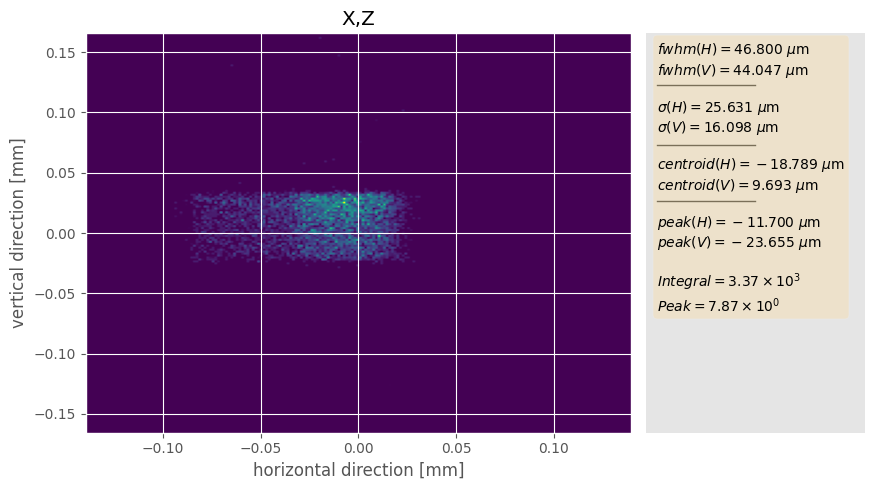

In [98]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[8.068679916808227]


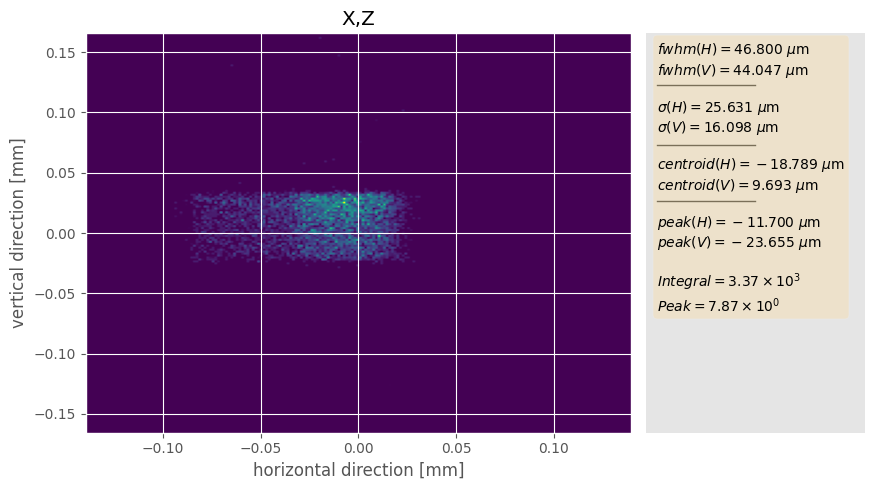

In [99]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

/tmp/ipykernel_3879159/1243347140.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

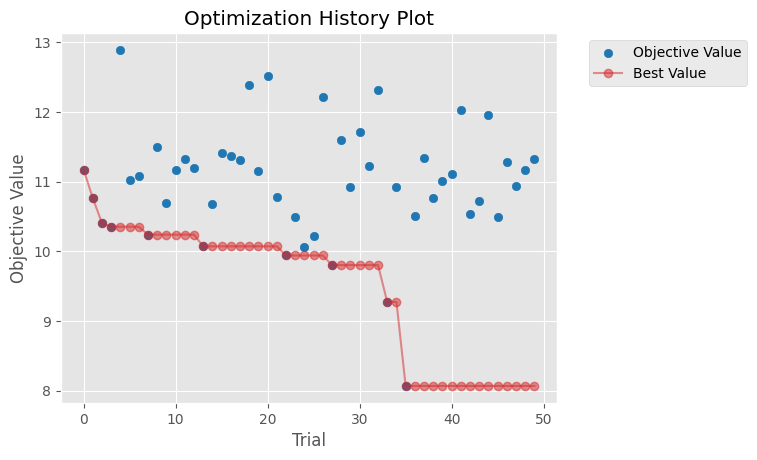

In [100]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)